# Simple Trajectory Tracking Demo
Track circular trajectory using TinyMPC hardware solver

In [7]:
import os
os.chdir("/home/xilinx/jupyter_notebooks/zhenyu/tinympc_ip_gen/")

import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Import dynamics module
from dynamics import LinearizedQuadcopterDynamics, CrazyflieParams, NoiseModel

# Import hardware solver
sys.path.append('driver')
from tinympc_hw import tinympc_hw

print("All modules imported successfully")

All modules imported successfully


## 1. Initialize System Parameters

In [9]:
# System parameters
control_freq = 100.0  # Control frequency Hz
dt = 1.0 / control_freq
sim_duration = 15.0  # Simulation duration in seconds
N = int(sim_duration * control_freq)  # Total steps
horizon = 5  # MPC prediction horizon

# Initialize dynamics model
params = CrazyflieParams()
noise_model = NoiseModel()
dynamics = LinearizedQuadcopterDynamics(params, noise_model)

# Generate system matrices
A, B = dynamics.generate_system_matrices(control_freq)
Q, R = dynamics.generate_cost_matrices()
constraints = dynamics.generate_constraints()

print(f"System dimensions: nx={A.shape[0]}, nu={B.shape[1]}")
print(f"Control frequency: {control_freq} Hz")
print(f"Prediction horizon: {horizon}")

System dimensions: nx=12, nu=4
Control frequency: 100.0 Hz
Prediction horizon: 5


## 2. Generate Circular Reference Trajectory

Reference trajectory generated: (12, 1500)
Trajectory radius: 1.5 m
Trajectory altitude: 1.2 m


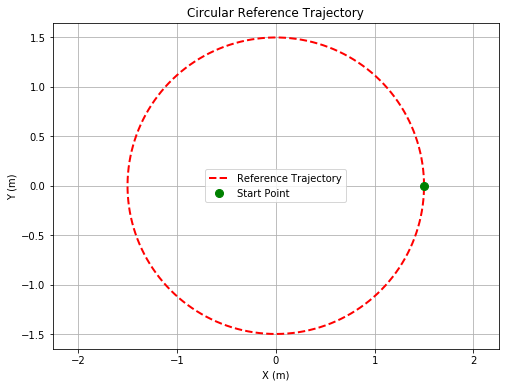

In [10]:
# Circular trajectory parameters
radius = 1.5  # Radius
center = [0, 0, 1.2]  # Center
omega = 2 * np.pi / sim_duration  # Angular velocity

# Generate time series
t = np.linspace(0, sim_duration, N)

# Generate reference trajectory (12-dimensional state)
X_ref = np.zeros((12, N))
X_ref[0, :] = center[0] + radius * np.cos(omega * t)  # x
X_ref[1, :] = center[1] + radius * np.sin(omega * t)  # y  
X_ref[2, :] = center[2]  # z (constant altitude)
X_ref[6, :] = -radius * omega * np.sin(omega * t)  # vx
X_ref[7, :] = radius * omega * np.cos(omega * t)   # vy
X_ref[8, :] = 0  # vz
# Other states remain zero

# Reference control inputs (hover)
U_ref = np.zeros((4, N-1))

print(f"Reference trajectory generated: {X_ref.shape}")
print(f"Trajectory radius: {radius} m")
print(f"Trajectory altitude: {center[2]} m")

# Visualize reference trajectory
plt.figure(figsize=(8, 6))
plt.plot(X_ref[0, :], X_ref[1, :], 'r--', linewidth=2, label='Reference Trajectory')
plt.plot(X_ref[0, 0], X_ref[1, 0], 'go', markersize=8, label='Start Point')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Circular Reference Trajectory')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

## 3. Initialize Hardware Solver

In [11]:
# Find available bitstream files
bitstream_path = "/home/xilinx/jupyter_notebooks/zhenyu/tinympc_ip_gen/bitstream/tinympcproj_N5_100Hz_float.bit"
mpc_hw = tinympc_hw(bitstream_path=bitstream_path)

use_hardware = True

Loading overlay from: /home/xilinx/jupyter_notebooks/zhenyu/tinympc_ip_gen/bitstream/tinympcproj_N5_100Hz_float.bit
Setting FCLK0 frequency from 99.999 MHz to 250 MHz
Clock frequency set to 249.9975 MHz
Found TinyMPC IP core: tinympc_solver_0
Allocated 164 float32 memory buffer at 0x0126e000
IP core initialized with memory address: 0x000000000126e000
  Lower 32 bits: 0x0126e000
  Upper 32 bits: 0x00000000
TinyMPC driver initialized successfully


## 4. Run Trajectory Tracking Simulation

In [12]:
# Initialize simulation state
x_current = X_ref[:, 0] + np.random.normal(0, 0.1, 12)  # Initial state (with some noise)
x_current[2] = max(x_current[2], 0.5)  # Ensure above ground

# Store history data
x_history = [x_current.copy()]
u_history = []

print(f"Starting simulation, total {N-1} steps...")
print(f"Initial position: [{x_current[0]:.3f}, {x_current[1]:.3f}, {x_current[2]:.3f}]")

# Simulation loop
for step in range(N-1):
    # Get reference trajectory segment for current time
    X_ref_horizon = np.zeros((12, horizon))
    U_ref_horizon = np.zeros((4, horizon-1))
    
    for i in range(horizon):
        ref_idx = min(step + i, N-1)
        X_ref_horizon[:, i] = X_ref[:, ref_idx]
    
    # Solve MPC problem
    if use_hardware and mpc_hw is not None:
        try:
            # Set problem data
            mpc_hw.set_x0(x_current)
            mpc_hw.set_x_ref(X_ref_horizon.T)  # Transpose to (N, nx)
            mpc_hw.set_u_ref(U_ref_horizon.T)  # Transpose to (N-1, nu)
            
            # Solve
            success = mpc_hw.solve(timeout=1.0)
            
            if success and mpc_hw.solved:
                u_control = mpc_hw.u[0, :] if len(mpc_hw.u) > 0 else np.zeros(4)
            else:
                u_control = np.zeros(4)  # Hover control
        except Exception as e:
            if step < 5:  # Only show errors in first few steps
                print(f"Step {step} hardware solve error: {e}")
            u_control = np.zeros(4)
    else:
        # Simple software simulation (PD controller)
        ref_pos = X_ref[:3, step]
        ref_vel = X_ref[6:9, step]
        
        pos_error = ref_pos - x_current[:3]
        vel_error = ref_vel - x_current[6:9]
        
        # Simple PD control
        kp = 2.0
        kd = 1.0
        u_control = np.array([
            params.mass * params.gravity + kp * pos_error[2] + kd * vel_error[2],  # thrust
            kp * pos_error[1] + kd * vel_error[1],  # roll torque
            kp * pos_error[0] + kd * vel_error[0],  # pitch torque  
            0.0  # yaw torque
        ])
    
    # Add actuator noise
    u_noisy = u_control * (1 + np.random.normal(0, 0.02, 4))
    
    # Forward simulation
    process_noise = np.random.normal(0, noise_model.get_state_noise_std(dt))
    gravity_disturbance = getattr(dynamics, 'gravity_disturbance', np.zeros(12))
    x_next = A @ x_current + B @ u_noisy + process_noise + gravity_disturbance
    
    # Apply constraints
    x_next = np.clip(x_next, constraints['x_min'], constraints['x_max'])
    
    # Store history
    x_current = x_next
    x_history.append(x_current.copy())
    u_history.append(u_control.copy())
    
    # Show progress
    if (step + 1) % 50 == 0:
        pos_error = np.linalg.norm(x_current[:3] - X_ref[:3, step])
        print(f"Step {step+1}/{N-1}, position error: {pos_error:.4f} m")

print("Simulation completed!")

# Convert to numpy arrays
x_history = np.array(x_history)
u_history = np.array(u_history)

print(f"Actual trajectory shape: {x_history.shape}")
print(f"Control input shape: {u_history.shape}")

Starting simulation, total 1499 steps...
Initial position: [1.430, -0.098, 1.229]
Parameters written: max_iter=100, check_termination_iter=10
Before start - Control: 0x00000004 (ready: False, idle: True)
IP started...
IP completed after 7 polls
Hardware execution completed in 0.0022 seconds
Parameters written: max_iter=100, check_termination_iter=10
Before start - Control: 0x00000004 (ready: False, idle: True)
IP started...
IP completed after 8 polls
Hardware execution completed in 0.0016 seconds
Parameters written: max_iter=100, check_termination_iter=10
Before start - Control: 0x00000004 (ready: False, idle: True)
IP started...
IP completed after 8 polls
Hardware execution completed in 0.0016 seconds
Parameters written: max_iter=100, check_termination_iter=10
Before start - Control: 0x00000004 (ready: False, idle: True)
IP started...
IP completed after 8 polls
Hardware execution completed in 0.0016 seconds
Parameters written: max_iter=100, check_termination_iter=10
Before start - Con

## 5. Visualize Trajectory Tracking Results

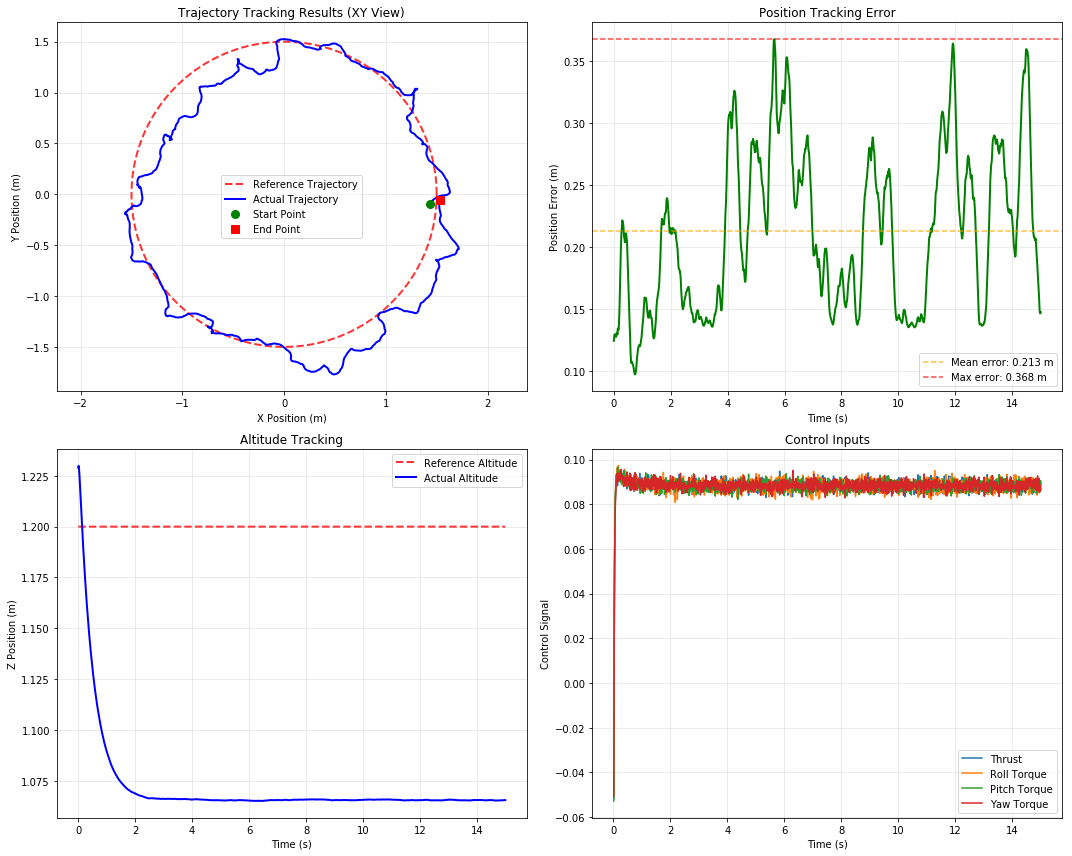


=== Trajectory Tracking Performance Statistics ===
Simulation duration: 15.0 seconds
Simulation steps: 1500 steps
Solver type: Hardware
Final position error: 0.1475 m
Mean position error: 0.2130 m
Max position error: 0.3679 m
Position error std dev: 0.0644 m
Trajectory completion error: 0.1475 m

Hardware solver information:
  Max iterations: 100
  Termination check interval: 10


In [13]:
# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. XY trajectory comparison
ax1.plot(X_ref[0, :], X_ref[1, :], 'r--', linewidth=2, label='Reference Trajectory', alpha=0.8)
ax1.plot(x_history[:, 0], x_history[:, 1], 'b-', linewidth=2, label='Actual Trajectory')
ax1.plot(x_history[0, 0], x_history[0, 1], 'go', markersize=8, label='Start Point')
ax1.plot(x_history[-1, 0], x_history[-1, 1], 'rs', markersize=8, label='End Point')
ax1.set_xlabel('X Position (m)')
ax1.set_ylabel('Y Position (m)')
ax1.set_title('Trajectory Tracking Results (XY View)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

# 2. Position error
position_errors = []
for i in range(len(x_history)):
    ref_idx = min(i, X_ref.shape[1]-1)
    error = np.linalg.norm(x_history[i, :3] - X_ref[:3, ref_idx])
    position_errors.append(error)

time_vec = np.linspace(0, sim_duration, len(position_errors))
ax2.plot(time_vec, position_errors, 'g-', linewidth=2)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Position Error (m)')
ax2.set_title('Position Tracking Error')
ax2.grid(True, alpha=0.3)

# Add error statistics
mean_error = np.mean(position_errors)
max_error = np.max(position_errors)
ax2.axhline(y=mean_error, color='orange', linestyle='--', alpha=0.7, 
           label=f'Mean error: {mean_error:.3f} m')
ax2.axhline(y=max_error, color='red', linestyle='--', alpha=0.7,
           label=f'Max error: {max_error:.3f} m')
ax2.legend()

# 3. Altitude tracking
ax3.plot(time_vec, X_ref[2, :len(time_vec)], 'r--', linewidth=2, label='Reference Altitude', alpha=0.8)
ax3.plot(time_vec, x_history[:, 2], 'b-', linewidth=2, label='Actual Altitude')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Z Position (m)')
ax3.set_title('Altitude Tracking')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Control inputs
if len(u_history) > 0:
    control_time = time_vec[1:len(u_history)+1]
    ax4.plot(control_time, u_history[:, 0], label='Thrust', linewidth=1.5)
    ax4.plot(control_time, u_history[:, 1], label='Roll Torque', linewidth=1.5)
    ax4.plot(control_time, u_history[:, 2], label='Pitch Torque', linewidth=1.5)
    ax4.plot(control_time, u_history[:, 3], label='Yaw Torque', linewidth=1.5)
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Control Signal')
    ax4.set_title('Control Inputs')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print performance statistics
print(f"\n=== Trajectory Tracking Performance Statistics ===")
print(f"Simulation duration: {sim_duration:.1f} seconds")
print(f"Simulation steps: {len(x_history)} steps")
print(f"Solver type: {'Hardware' if use_hardware else 'Software PD Control'}")
print(f"Final position error: {position_errors[-1]:.4f} m")
print(f"Mean position error: {mean_error:.4f} m")
print(f"Max position error: {max_error:.4f} m")
print(f"Position error std dev: {np.std(position_errors):.4f} m")

# Calculate trajectory completion
final_pos = x_history[-1, :3]
target_pos = X_ref[:3, -1]
completion_error = np.linalg.norm(final_pos - target_pos)
print(f"Trajectory completion error: {completion_error:.4f} m")

if use_hardware and mpc_hw is not None:
    print(f"\nHardware solver information:")
    print(f"  Max iterations: {mpc_hw.max_iter}")
    print(f"  Termination check interval: {mpc_hw.check_termination}")

## Summary

This simple demo demonstrates:
1. Real-time trajectory tracking using TinyMPC hardware solver
2. Generation and tracking of circular reference trajectory
3. Visualization and analysis of trajectory tracking performance
4. Switching between hardware solver and software fallback

If the hardware solver is unavailable, the system will automatically switch to a simple PD controller for software simulation.